# BERTopic

In [1]:
import sys
sys.path.insert(0, '..')
from utils.preprocesamiento import df_to_list

In [2]:
op_left, op_right = 'Producir el alimento', 'Resguardar tradiciones'

In [3]:
import pandas as pd
from utils.cargar import df_caso
from utils.preprocesamiento import process_df, procesar_adela

caso = 'adela'
df = df_caso(caso)

df = procesar_adela(df)
df = df[df['opt_left'] == 'Producir el alimento contra déficit vitamínico']

df = process_df(df,'comment','sel',verbose=True)

train_indices = pd.read_csv('../utils/splits/train_indices_{}.csv'.format(caso), header=None)[0].tolist()
test_indices = pd.read_csv('../utils/splits/test_indices_{}.csv'.format(caso), header=None)[0].tolist()
print("Partición train-test cargada")

df_train = df.iloc[train_indices]
df_test = df.iloc[test_indices]

26 rows found with non string elements for column comment (0.40%)
Deleting 685 columns for which max target value is over 7 (10.58%)
5761 available rows after processing
Partición train-test cargada


Guardando la partición train-test

In [4]:
from utils.preprocesamiento import StemmerTokenizer

tokenizador = StemmerTokenizer(stem=False,rmv_punctuation=True)

docs_train = df_to_list(df_train,'comment',tokenizador)
docs_test = df_to_list(df_test, 'comment',tokenizador)

## BERTopic algorithm

In [5]:
from IPython.display import Image, display
display(Image(url='https://maartengr.github.io/BERTopic/algorithm/modularity.svg'))

In [6]:
%%capture
from bertopic import BERTopic

In [7]:
num_topics = 10
model = BERTopic(language="spanish",min_topic_size=5,nr_topics=num_topics,calculate_probabilities=True)

In [8]:
%%time
topics, probs = model.fit_transform(docs_train)

CPU times: user 1min 5s, sys: 2.55 s, total: 1min 7s
Wall time: 35 s


In [9]:
model.get_topic_freq().head(5)

,Topic,Count
0,0,2449
1,-1,1961
2,1,634
4,2,221
3,3,88


In [10]:
model.get_topic(0)[:10]

[('alimento', 0.046429723557414544),
 ('tradiciones', 0.04200582901419748),
 ('pueblo', 0.036306248466687854),
 ('producir', 0.032102671194072334),
 ('importante', 0.02860681798164325),
 ('adela', 0.028586104108929162),
 ('fruta', 0.028292492632456347),
 ('debería', 0.027899680081711835),
 ('si', 0.02699091755344607),
 ('producción', 0.025740632817732312)]

Topicos para algunos documentos

In [11]:
for i, t in enumerate(model.topics_[:10]):
    print('Tópico {}:\ttexto: {}'.format(t,docs_train[i]))

Tópico 0:	texto: Adela debería priorizar salud personas alguna creencia grupo pequeño personas
Tópico 0:	texto: Dado Adela quiere utilizar fruto tradicional pueblo originario cuál esforzado cultivar mantener vigente debería respetar condiciones pueblo originario acepta uso fruto encargados hacerlo subsistir
Tópico -1:	texto: Si bien aún proyecto obligacion considerar opinión pueblos originarios demasía importante considerar opinión respeto cultura cosmovisión Lamenetablemente existe disgusto parte últimos proyecto existirá conflicto fututo hora producir producto Lo prudente realizar estudio baja escala implementando producción alimento compromiso incluir miembros comunidades indígenas llegar acuerdos conjunto
Tópico -1:	texto: Debe priorizar producción alimento pues trata deficiencia salud puede llegar generar problemas graves si tratan todas formas seguiría tratando lograr acuerdo pueblo originario si logra terminaría priorizando producción alimento
Tópico -1:	texto: Considero debería

### Inferencia en conjunto test

In [12]:
string = 'Aun considero necesario resguardar mas tradiciones identitarias embargo producir alimento podría ayudar muchas personas entonces debería existir diálogo ambas partes llegar mejor solución'

model.transform([string])

([-1],
 array([[3.58201418e-01, 1.28971698e-01, 4.97833529e-02, 3.10924964e-02,
         1.67405208e-04, 8.61473959e-03, 6.19630784e-03, 3.61856816e-03,
         1.03395685e-04]]))

In [13]:
output = model.transform(df_to_list(df_test.iloc[:3],'comment',tokenizador))

Imprimiendo los embeddings

In [14]:
output[1]

array([[3.98162784e-01, 1.30254830e-01, 4.51300943e-02, 1.71253306e-02,
        1.00222628e-02, 8.94290357e-03, 6.14477563e-03, 3.29879802e-03,
        4.68007531e-03],
       [4.64444883e-01, 4.77916297e-64, 1.57425100e-64, 6.85008417e-65,
        4.48887622e-66, 3.20191884e-65, 2.23177037e-65, 1.24374954e-65,
        2.80267632e-66],
       [3.85238951e-01, 3.84912706e-02, 1.40823867e-02, 6.60814219e-03,
        3.06881496e-06, 2.80617449e-03, 1.98553450e-03, 1.18305224e-03,
        1.91432830e-06]])

In [15]:
output[0]

[0, -1, -1]

Visualización

In [16]:
model.visualize_topics()

Podemos relacionar tópicos con palabras en específico

In [17]:
target = 'integridad'

topic_num = 5

similar_topics, similarity = model.find_topics(target, top_n=topic_num)
similar_topics

[5, 1, 3, 6, 2]

In [18]:
similarity

[0.5515804090192521,
 0.3145556935647881,
 0.30870191438230266,
 0.28784286509073453,
 0.24968738888005088]

In [19]:
from TM_utils import get_table_top_topics
from utils.exploracion import print_table_md

print("Tópicos relevantes para concepto: {}".format(target))

headers, data = get_table_top_topics(model,similar_topics,similarity,max_w=5)
print_table_md(headers, data)

Tópicos relevantes para concepto: integridad


| Tópico | Probabilidad | Palabra 1 | Palabra 2 | Palabra 3 | Palabra 4 | Palabra 5 |
| --- | --- | --- | --- | --- | --- | --- |
| 5 | 0.5515804090192521 | postura | mantengo | no | creo | modifico |
| 1 | 0.3145556935647881 | tradiciones | pueblo | acuerdo | importante | llegar |
| 3 | 0.30870191438230266 | proyecto | innovación | si | acuerdo | pueblos |
| 6 | 0.28784286509073453 | opinión | opinion | mi | misma | mantiene |
| 2 | 0.24968738888005088 | salud | importante | personas | tradiciones | creencias |


Distribución de tópicos en test set

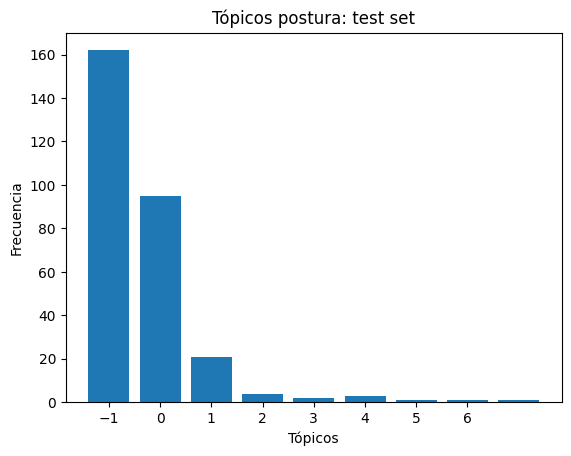

In [20]:
from TM_utils import plot_frecuencies, get_top_k_topics, get_table_top_topics
from utils.exploracion import print_table_md
from utils.preprocesamiento import StemmerTokenizer

tokenizador = StemmerTokenizer(stem=False,rmv_punctuation=True)

output_test = model.transform(df_to_list(df_test,'comment',tokenizador))

plot_frecuencies(output_test[0],label='test set')

In [21]:
top_5_keys, top_5_values = get_top_k_topics(output_test[0],k=5)
print("Tópicos relevantes en test set")

headers, data = get_table_top_topics(model,top_5_keys,top_5_values,max_w=5)
print_table_md(headers, data)

Tópicos relevantes en test set


| Tópico | Probabilidad | Palabra 1 | Palabra 2 | Palabra 3 | Palabra 4 | Palabra 5 |
| --- | --- | --- | --- | --- | --- | --- |
| -1 | 0.5586206896551724 | tradiciones | pueblo | alimento | si | importante |
| 0 | 0.3275862068965517 | alimento | tradiciones | pueblo | producir | importante |
| 1 | 0.07241379310344828 | tradiciones | pueblo | acuerdo | importante | llegar |
| 2 | 0.013793103448275862 | salud | importante | personas | tradiciones | creencias |
| 4 | 0.010344827586206896 | chile | relleno | chilena | población | pueblo |


In [43]:
from TM_utils import get_k_random_samples_from_topic

for j, topic in enumerate(top_5_keys):
    df_samples, certainties = get_k_random_samples_from_topic(df_test,output_test,topic)

    print("Ejemplos para tópico ", topic,"\tProporción:","%.1f"%(100*top_5_values[j])+'%')
    for i in range(len(df_samples)):
        print("Sel :",df_samples.iloc[i]['sel'],"\tCertainty: ","%.3f"%(certainties[i]),"\nTexto:", df_samples.iloc[i]['comment'])
    print('\n')

Ejemplos para tópico  -1 	Proporción: 62.2%
Sel : 5 	Certainty:  0.000 
Texto: Es importante que el pueblo se sienta cómodo con la solución presentada, ya que si no, podría darse el caso en el que simplemente no quieran consumir aquel alimento, llegando a un problema ya que no estaría aportando nada, en tal caso que se llegara a una solución que no pase a llevar el pueblo me parecería bien
Sel : 4 	Certainty:  0.000 
Texto: Nuevamente opiné lo mismo que a lo llegado en la discusión. Creo que se podría intentar en primera instancia dialogar con el pueblo originario para llegar a un acuerdo para el uso adecuado del fruto. Según lo visto en el texto leído, estos estaban siendo considerados en el uso del fruto, y estos manifestaron una molestia en el proceso de como se mantenía el fruto más en el hecho de que lo estaban usando. En ese sentido un acuerdo puede ser posible al intentar buscar otro proceso que no 'pase a llevar' estas tradiciones. Sin embargo, si no se logra un acuerdo es impo

### Analizando correlaciones con selección de postura

Por el momento binarizando la postura

In [26]:
df_test.loc[(df_test['sel']==2) | (df_test['sel']==3),'sel'] = 1
df_test.loc[(df_test['sel']==4) | (df_test['sel']==5),'sel'] = 6

In [27]:
output_sel1 = model.transform(df_to_list(df_test[df_test['sel']==1],'comment',tokenizador))

In [28]:
output_sel6 = model.transform(df_to_list(df_test[df_test['sel']==6],'comment',tokenizador))

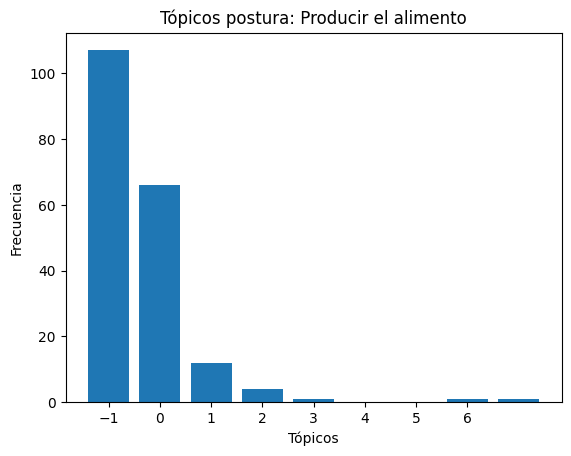

In [29]:
import matplotlib.pyplot as plt

def plot_frecuencies(input_list,label):
    frequency_dict = {}
    for element in input_list:
        if element in frequency_dict:
            frequency_dict[element] += 1
        else:
            frequency_dict[element] = 1
    counts = frequency_dict

    # Switching to the OO-interface. You can do all of this with "plt" as well.
    fig, ax = plt.subplots()

    keys = counts.keys()
    values = counts.values()

    plt.bar(keys, values)

    custom_ticks = list(range(-1,max(input_list)))
    plt.xticks(custom_ticks)

    plt.xlabel('Tópicos')
    plt.ylabel('Frecuencia')
    plt.title('Tópicos postura: {}'.format(label))

    plt.show()

plot_frecuencies(output_sel1[0],label=op_left)

In [30]:
def get_top_k_topics(input_list,k=5):

    frequency_dict = {}
    for element in input_list:
        if element in frequency_dict:
            frequency_dict[element] += 1
        else:
            frequency_dict[element] = 1

    # Sort the dictionary items by their values in descending order
    sorted_items = sorted(frequency_dict.items(), key=lambda x: x[1], reverse=True)

    # Get the top 5 keys with the largest values
    top_k_keys = [item[0] for item in sorted_items[:k]]
    top_k_values = [item[1] for item in sorted_items[:k]]

    top_k_values = [elem/len(input_list) for elem in top_k_values]

    return top_k_keys, top_k_values

top_5_keys, top_5_values = get_top_k_topics(output_sel1[0])

print("Tópicos relevantes para postura: {}".format(op_left))

headers, data = get_table_top_topics(model,top_5_keys,top_5_values,max_w=5)
print_table_md(headers, data)

Tópicos relevantes para postura: Producir el alimento


| Tópico | Probabilidad | Palabra 1 | Palabra 2 | Palabra 3 | Palabra 4 | Palabra 5 |
| --- | --- | --- | --- | --- | --- | --- |
| -1 | 0.5572916666666666 | tradiciones | pueblo | alimento | si | importante |
| 0 | 0.34375 | alimento | tradiciones | pueblo | producir | importante |
| 1 | 0.0625 | tradiciones | pueblo | acuerdo | importante | llegar |
| 2 | 0.020833333333333332 | salud | importante | personas | tradiciones | creencias |
| 7 | 0.005208333333333333 | ciencia | desarrollo | humano | camino | tecnológicamente |


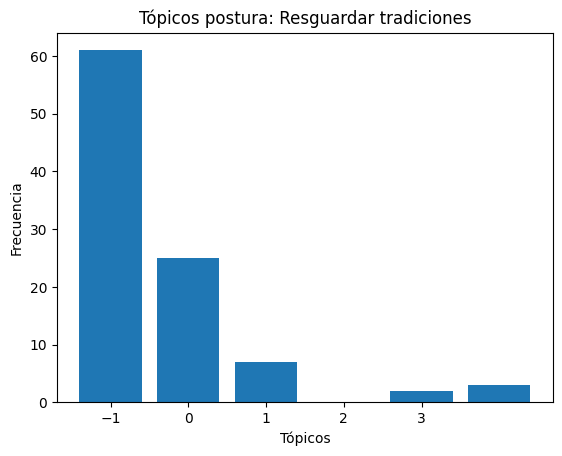

In [31]:
plot_frecuencies(output_sel6[0],label=op_right)

In [32]:
top_5_keys, top_5_values = get_top_k_topics(output_sel6[0])

print("Tópicos relevantes para postura: {}".format(op_right))

headers, data = get_table_top_topics(model,top_5_keys,top_5_values,max_w=5)
print_table_md(headers, data)

Tópicos relevantes para postura: Resguardar tradiciones


| Tópico | Probabilidad | Palabra 1 | Palabra 2 | Palabra 3 | Palabra 4 | Palabra 5 |
| --- | --- | --- | --- | --- | --- | --- |
| -1 | 0.6224489795918368 | tradiciones | pueblo | alimento | si | importante |
| 0 | 0.25510204081632654 | alimento | tradiciones | pueblo | producir | importante |
| 1 | 0.07142857142857142 | tradiciones | pueblo | acuerdo | importante | llegar |
| 4 | 0.030612244897959183 | chile | relleno | chilena | población | pueblo |
| 3 | 0.02040816326530612 | proyecto | innovación | si | acuerdo | pueblos |


### Correlaciones

In [33]:
df_test = df.iloc[test_indices]
df_test['sel'].value_counts()

sel
3    87
2    74
4    51
5    35
1    31
6    12
Name: count, dtype: int64

In [36]:
import pandas as pd

arr_test = model.transform(df_to_list(df_test,'comment',tokenizador))[1]
df_topics = pd.DataFrame(arr_test, columns=['Topic{}'.format(i+1) for i in range(num_topics-1)])

df_topics['sel'] = df_test['sel'].values

In [37]:
from scipy.stats import pearsonr

# Only compute pearson prod-moment correlations between feature
# columns and target column
target_col_name = 'sel'
feature_target_corr = {}
for col in df_topics:
    if target_col_name != col:
        feature_target_corr[col + '_' + target_col_name] = \
            pearsonr(df_topics[col], df_topics[target_col_name])[0]
print("Feature-Target Correlations")

for k in feature_target_corr.keys():
    print(k+': '+str(feature_target_corr[k]))

Feature-Target Correlations
Topic1_sel: -0.12736581646323647
Topic2_sel: 0.13785893965290472
Topic3_sel: -0.10727776067021759
Topic4_sel: 0.0766952709086156
Topic5_sel: 0.14814602091371454
Topic6_sel: -0.02473773389275401
Topic7_sel: -0.003801062005934731
Topic8_sel: -0.04993331693130397
Topic9_sel: 0.00970281116128164


Guardando el modelo

In [38]:
model.save("modelos/BT-{}.bertopic".format(caso))

Para cargar:

`my_model = BERTopic.load("modelos/BT-caso")`